In [1]:
import einops
import torch

from einops.layers.torch import EinMix

from utils.components import *
from utils.config import *
from utils.einmask import EinMask

from utils.masking import *

import itertools

In [2]:
import matplotlib.pyplot as plt

In [63]:
world = WorldConfig(field_sizes={"v": 5, "t": 36, "h": 64, "w": 120}, patch_sizes={'vv': 5, 'tt': 6, 'hh': 4, 'ww': 4}, batch_size=16)

In [4]:
network = NetworkConfig(dim=512, num_latents=32, num_layers=12, num_tails=4, use_checkpoint=False, dim_in=256, dim_coords=64,
                        wavelengths=[(1,8),(1,8),(1,64),(1,128)])

In [5]:
cpe = ContinuousPositionalEmbedding(
    network.dim_coords, network.wavelengths
)

In [6]:
model = EinMask(network=network, world=world)

In [7]:
p = cpe(model.coordinates)

AttributeError: 'Embedding' object has no attribute 'device'

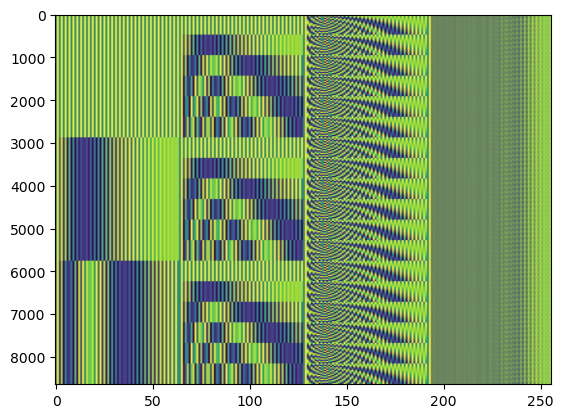

In [ ]:
plt.imshow(p, aspect="auto")

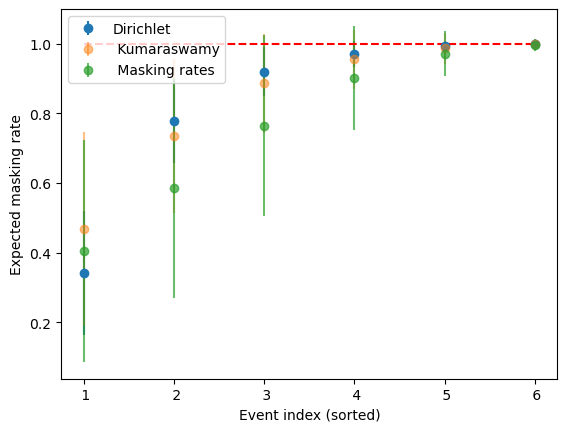

In [119]:
mm = MultinomialMasking(objective=ObjectiveConfig(alpha= 0.2, c1= 1, c0=3, prior='kumaraswamy'), world=world)
u = mm.sample_kumaraswamy(shape=(1000,), rng=None)
t = 1 - u.sort(dim=-1, descending=True).values 

samples = mm.sample_dirichlet(shape=(1000,), rng=None)
samples = 1 - samples.sort(dim=-1, descending=True).values 


masks = []
for _ in range(1000):
    mask = mm((1, ), rng=None)[0]
    mask = mask // 480
    mask = mask.squeeze().bincount(minlength=6) / 480
    masks.append(mask)
masks = torch.stack(masks, dim=0)
rates = 1 - masks.sort(dim=1, descending=True).values

plt.errorbar(x = torch.arange(6), y = samples.mean(dim=0), yerr=samples.std(dim=0), fmt='o', label='Dirichlet')
plt.errorbar(x = torch.arange(6), y = t.mean(dim=0), yerr=t.std(dim=0), fmt='o', label=' Kumaraswamy', alpha=0.5)
plt.errorbar(x = torch.arange(6), y = rates.mean(dim=0), yerr=rates.std(dim=0), fmt='o', label=' Masking rates', alpha=0.7)

plt.ylabel('Expected masking rate')
plt.xticks(ticks= torch.arange(6), labels= [f' {i+1}' for i in range(6)])
plt.xlabel('Event index (sorted)')
plt.legend()
plt.hlines(1, 0, 5, colors='red', linestyles='dashed')

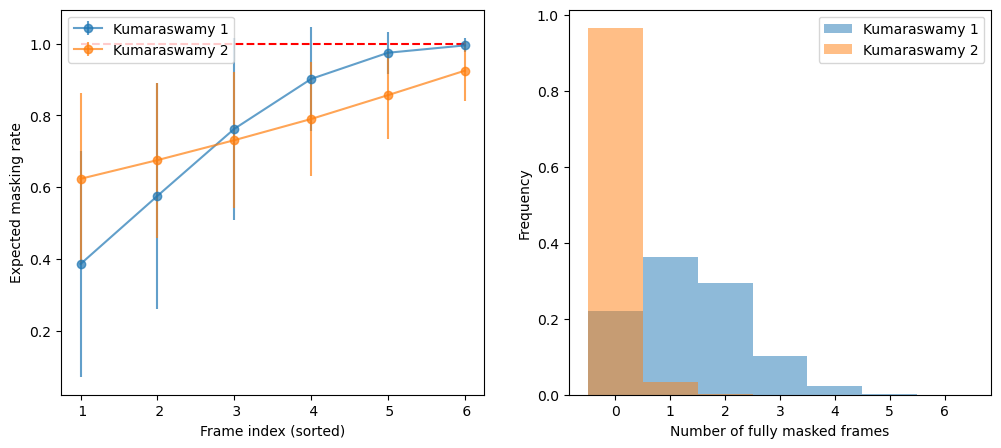

In [147]:
mm = MultinomialMasking(objective=ObjectiveConfig(alpha= 0.2, c1= 1, c0=3, prior='kumaraswamy'), world=world)
mm2 = MultinomialMasking(objective=ObjectiveConfig(alpha= 1, c1= 1, c0=3, prior='kumaraswamy'), world=world)


masks = []
for _ in range(1000):
    mask = mm((1, ), rng=None)[0]
    mask = mask // 480
    mask = mask.squeeze().bincount(minlength=6) / 480
    masks.append(mask)
masks = torch.stack(masks, dim=0)
rates = 1 - masks.sort(dim=1, descending=True).values

masks2 = []
for _ in range(1000):
    mask = mm2((1, ), rng=None)[0]
    mask = mask // 480
    mask = mask.squeeze().bincount(minlength=6) / 480
    masks2.append(mask)
masks2 = torch.stack(masks2, dim=0)
rates2 = 1 - masks2.sort(dim=1, descending=True).values


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.errorbar(x = torch.arange(6), y = rates.mean(dim=0), yerr=rates.std(dim=0), fmt='o-', label='Kumaraswamy 1', alpha=0.7)
plt.errorbar(x = torch.arange(6), y = rates2.mean(dim=0), yerr=rates2.std(dim=0), fmt='o-', label='Kumaraswamy 2', alpha=0.7)

plt.ylabel('Expected masking rate')
plt.xticks(ticks= torch.arange(6), labels= [f' {i+1}' for i in range(6)])
plt.xlabel('Frame index (sorted)')
plt.legend()
plt.hlines(1, 0, 5, colors='red', linestyles='dashed')

nums1 = (rates == 1).sum(dim=1)
nums2 = (rates2 == 1).sum(dim=1)
plt.subplot(1,2,2)
plt.hist(nums1.numpy(), bins= torch.arange(8)-0.5, alpha=0.5, density=True, label='Kumaraswamy 1')
plt.hist(nums2.numpy(), bins= torch.arange(8)-0.5, alpha=0.5, density=True, label='Kumaraswamy 2')
plt.xlabel('Number of fully masked frames')
plt.ylabel('Frequency')
plt.legend()

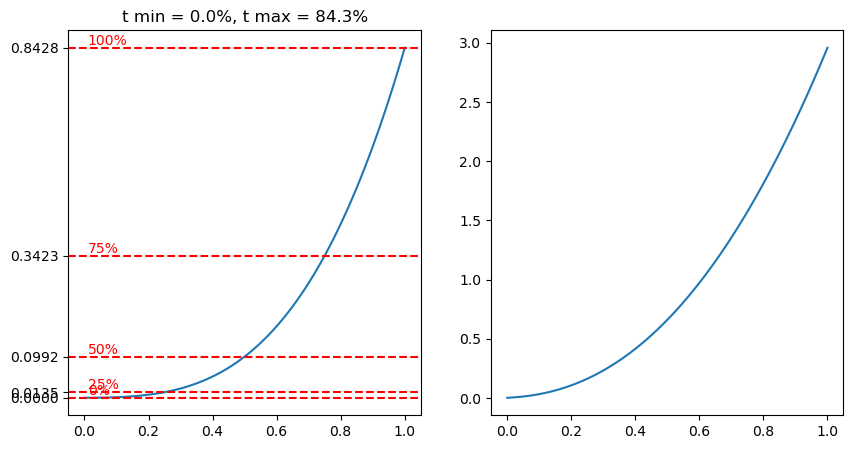

In [106]:
u = torch.linspace(0,1,100)
c0 = 1.
c1 = 0.3
k_min = 0
k_max = 1
km = KumaraswamySchedule(objective=ObjectiveConfig(c1=c1, c0=c0))
t = km(u)[0]
t = k_min + (k_max - k_min) * t
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(u, t)
plt.title(f"t min = {100*t.min().item()/k_max:.1f}%, t max = {100*t.max().item()/k_max:.1f}%")
# add quantile lines
qtls = [0, 0.25, 0.5, 0.75, 1]
for q in qtls:
    uq = torch.tensor(q).unsqueeze(0)
    tq = km(uq)[0]
    tq = k_min + (k_max - k_min) * tq
    plt.axhline(tq.item(), color='red', linestyle='--')
    plt.text(0.01, tq.item(), f"{q*100:.0f}%", color='red', va='bottom')
# add tick marks on y axis at quantiles
plt.yticks([k_min + (k_max - k_min) * km(torch.tensor(q).unsqueeze(0))[0].item() for q in qtls])
plt.subplot(1,2,2)
plt.plot(u, km(u)[1])


In [11]:
print(f"min masking rate {100*t.max()/k_max:.1f}%, max masking rate {100*t.min()/k_max:.2f}%")

min masking rate 52.7%, max masking rate 1.28%


Text(0, 0.5, 'masking rate')

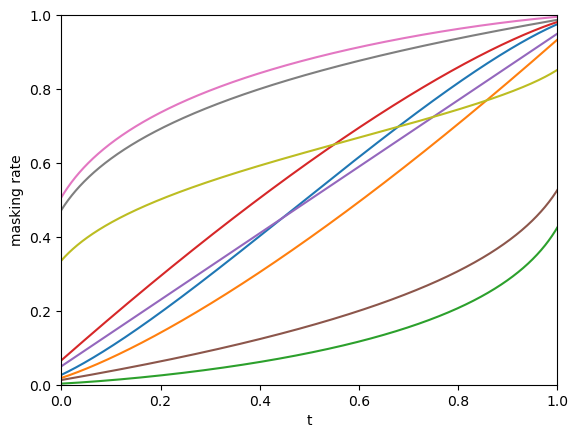

In [13]:
u = torch.linspace(0,1,1000)

for c1, c0 in itertools.product([ 0.75, 1, 4],[ 0.75, 1, 4]):
    km = KumaraswamySchedule(objective=ObjectiveConfig(c1=c1, c0=c0))
    plt.plot(u, km(u)[0])

plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('t')
plt.ylabel('masking rate')

In [14]:
# scaling reference

# S = 64 latents, 512 dim, 256 dim_in, 8 layers
# M = 256 latents, 768 dim, 512 dim_in, 16 layers
# L = 512 latents, 1024 dim, 512 

In [1]:
import yaml
from copy import deepcopy
from itertools import product

# -------------------------
# Base YAML (verbatim)
# -------------------------

BASE_YAML = {
    "defaults": {
        "world": {
            "batch_size": 32,
            "field_sizes": {
                "v": "${len:${data.variables}}",
                "t": "${data.sequence_length}",
                "h": 64,
                "w": 120,
            },
            "patch_sizes": {
                "vv": 5,
                "tt": 6,
                "hh": 4,
                "ww": 4,
            },
        },
        "objective": {
            "prior": "dirichlet",
            "c1": 1.0,
            "c0": 5.0,
            "alpha": 0.5,
            "event_dims": ["t"],
        },
        "model": {
            "num_latents": 256,
            "num_layers": 16,
            "num_tails": 8,
            "dim": 768,
            "dim_in": 512,
            "dim_coords": 64,
            "drop_path": 0.25,
            "wavelengths": [
                [1, 16],
                [1, 16],
                [1, 32],
                [1, 64],
            ],
        },
        "data": {
            "sequence_length": 36,
            "variables": [
                "temp_ocn_0a",
                "temp_ocn_3a",
                "temp_ocn_8a",
                "temp_ocn_14a",
                "tauxa",
            ],
            "eval_variables": ["temp_ocn_0a"],
            "max_dirs": 50,
            "eval_data": "piControl",
        },
        "trainer": {
            "seed": 1,
            "job_name": None,
            "stage1_id": None,
            "num_workers": 8,
            "use_wandb": True,
            "wb_project": "einmask",
            "wb_tags": ["sweep"],
            "resume_training": False,
            "val_loss_name": "loss",
            "scheduler_step": "batch",
            "spectral_loss_weight": 0.0,
            "lr": 1e-4,
            "beta1": 0.9,
            "beta2": 0.95,
            "weight_decay": 0.01,
            "schedulers": [
                {
                    "type": "linear",
                    "steps": 5000,
                    "start_factor": 1e-5,
                    "end_factor": 1.0,
                },
                {
                    "type": "cosine",
                    "steps": 295000,
                    "eta_min": 1e-5,
                },
            ],
            "use_ema": True,
            "ema_decay": 0.9999,
            "use_zero": False,
            "save_eval": False,
            "picontrol_path": "/mnt/lustre/work/ludwig/jthuemmel54/data/CMIP6_LENS/CESM2/piControl/temp_ocean_1_2_grid/processed",
            "lens_path": "/mnt/lustre/work/ludwig/jthuemmel54/data/CMIP6_LENS/CESM2/historical_levels/temp_ocean/1_2_grid/all_ensembles",
            "godas_path": "/mnt/lustre/work/ludwig/jthuemmel54/data/enso_data_pacific/godas/temp_ocean/1_2_grid",
            "oras5_path": "/mnt/lustre/work/ludwig/jthuemmel54/data/enso_data_pacific/oras5/temp_ocean/1_2_grid",
            "model_dir": "/mnt/lustre/work/ludwig/jthuemmel54/thesis/runs/",
        },
    },
}

# -------------------------
# Sweep generation
# -------------------------

def generate_tasks():
    task_id = 1
    tasks = {}

    # -------- Block 1: Dirichlet alpha --------
    for alpha in [0.01, 0.1, 0.5, 1.0, 10.0]:
        for seed in [12, 13]:
            tasks[str(task_id)] = {
                "objective": {"alpha": alpha, "prior": "dirichlet"},
                "trainer": {"seed": seed, "wb_tags": ["sweep", "dirichlet_alpha"]},
            }
            task_id += 1

    # -------- Block 2: Event dims x alpha --------
    event_sets = [
        ["t"],
        ["h", "w"],
        ["t", "h", "w"],
    ]
    for event_dims, alpha in product(
        event_sets, [0.0, 0.1, 0.3, 0.5, 0.7]
    ):
        for seed in [12, 13]:
            tasks[str(task_id)] = {
                "objective": {
                    "event_dims": list(event_dims),
                    "alpha": alpha,
                    "prior": "binomial",
                },
                "trainer": {"seed": seed, "wb_tags": ["sweep", "event_dims"]},
            }
            task_id += 1

    # -------- Block 3: Model x dataset sizes --------
    models = {
        "S": dict(dim=512, dim_in=256, num_latents=64, num_layers=8, batch_size=64),
        "M": dict(dim=768, dim_in=512, num_latents=256, num_layers=16, batch_size=32),
        "L": dict(dim=1024, dim_in=768, num_latents=512, num_layers=24, batch_size=16),
    }

    for model_cfg, max_dirs, steps in product(
        models.values(),
        [20, 60, 100],
        [95000, 195000, 295000],
    ):
        for seed in [12, 13]:
            tasks[str(task_id)] = {
                "world": {"batch_size": model_cfg["batch_size"]},
                "model": {
                    "dim": model_cfg["dim"],
                    "dim_in": model_cfg["dim_in"],
                    "num_latents": model_cfg["num_latents"],
                    "num_layers": model_cfg["num_layers"],
                },
                "data": {"max_dirs": max_dirs},
                "trainer": {
                    "seed": seed,
                    "wb_tags": ["sweep", "model_size", "data_size"],
                    "schedulers": [
                        {
                            "type": "linear",
                            "steps": 5000,
                            "start_factor": 1e-5,
                            "end_factor": 1.0,
                        },
                        {
                            "type": "cosine",
                            "steps": steps,
                            "eta_min": 1e-5,
                        },
                    ],
                },
            }
            task_id += 1

    # -------- Block 4: Hyperparameters --------

    # LR sweep
    for lr in [1e-4, 5e-4, 5e-5]:
        tasks[str(task_id)] = {
            "trainer": {"lr": lr, "wb_tags": ["sweep", "lr"]},
        }
        task_id += 1

    # Eta min sweep (cosine scheduler only)
    for eta_min in [1e-5, 1e-6, 1e-7]:
        tasks[str(task_id)] = {
            "trainer": {
                "wb_tags": ["sweep", "eta_min"],
                "schedulers": [
                    {
                        "type": "linear",
                        "steps": 5000,
                        "start_factor": 1e-5,
                        "end_factor": 1.0,
                    },
                    {
                        "type": "cosine",
                        "steps": 295000,
                        "eta_min": eta_min,
                    },
                ]
            }
        }
        task_id += 1

    # Weight decay sweep
    for wd in [0.0, 0.1, 0.05, 0.001]:
        tasks[str(task_id)] = {
            "trainer": {"weight_decay": wd, "wb_tags": ["sweep", "weight_decay"]},
        }
        task_id += 1

    # Drop path sweep
    for dp in [0.0, 0.1, 0.25]:
        tasks[str(task_id)] = {
            "model": {"drop_path": dp},
            "trainer": {"wb_tags": ["sweep", "drop_path"]},
        }
        task_id += 1

    # EMA on/off
    for ema in [True, False]:
        tasks[str(task_id)] = {
            "trainer": {"use_ema": ema, "wb_tags": ["sweep", "use_ema"]},
        }
        task_id += 1

    # Spectral loss weight sweep
    for w in [0.0, 0.1, 0.01]:
        tasks[str(task_id)] = {
            "trainer": {"spectral_loss_weight": w, "wb_tags": ["sweep", "spectral_loss_weight"]},
        }
        task_id += 1

    # -------- Block 5: Patch configs --------
    for hh, ww, tt, vv in product([4, 8], [4, 8], [3, 6], [1, 5]):
        tasks[str(task_id)] = {
            "world": {
                "batch_size": 16,
                "patch_sizes": {
                    "hh": hh,
                    "ww": ww,
                    "tt": tt,
                    "vv": vv,
                },
            },
            "trainer": {"wb_tags": ["sweep", "patch_sizes"]},
        }
        task_id += 1

    return tasks


# -------------------------
# Emit YAML
# -------------------------

def main(outfile="sweep.yaml"):
    yaml_out = deepcopy(BASE_YAML)
    yaml_out.update(generate_tasks())

    with open(outfile, "w") as f:
        yaml.safe_dump(
            yaml_out,
            f,
            sort_keys=False,
            default_flow_style=False,
        )


if __name__ == "__main__":
    main()
